In [1]:
import sys
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb
import catboost as ctb
from collections import defaultdict 

from sklearn.model_selection import GroupShuffleSplit, cross_val_predict, learning_curve, StratifiedKFold, KFold

from sklearn import metrics 
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.metrics import mean_squared_error as mse

import scikitplot as skplt 
import matplotlib.pyplot as plt

import gc
from ggplot import *

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error as mse, precision_score, recall_score
from sklearn import utils

from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve
from scikitplot.estimators import plot_learning_curve, plot_feature_importances

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from collections import defaultdict 

import gc
import eli5
from eli5.sklearn import PermutationImportance

#%matplotlib inline

Using TensorFlow backend.


In [3]:
## read data
# train = pd.read_hdf('../input/train_online_retail.h5')
# test = pd.read_hdf('../input/test_online_retail.h5')
train = pd.read_hdf('/home/dlc/projects/ppml/module3/input/train_online_retail.h5')
test = pd.read_hdf('/home/dlc/projects/ppml/module3/input/test_online_retail.h5')

df_all = pd.concat([train, test], sort=False)

## release memory
del train, test
gc.collect()



22

In [4]:
%%time
by_stock = df_all[df_all["customer_id"] != -1].groupby(
    ["stock_code"]
)["price_unit"].agg(
    price=lambda x: x.value_counts(normalize=True).index[0]
)

stock_to_price = by_stock["price"].to_dict()

CPU times: user 4.45 s, sys: 46.5 ms, total: 4.5 s
Wall time: 4.5 s


In [5]:
from collections import ChainMap


def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['is_canceled', 'is_test']
    return [x for x in feats if x not in black_list]


def adjust_dataset(_dataset):
    dataset = _dataset.copy(deep=True)
#     dataset["price_unit"] = dataset.apply(
#         lambda x: stock_to_price.get(x["stock_code"], 1e-5), 
#         axis=1
#     )
#     dataset["price_total"] = dataset["quantity"] * dataset["price_unit"]
    dataset["invoice"] = dataset["invoice"].astype(int)
    dataset["customer_id"] = dataset["customer_id"].astype(int)
    dataset["stock_code"] = dataset["stock_code"].astype(int)
    return dataset

In [6]:
%%time
#feature engineering
raw = adjust_dataset(df_all)
raw_train = raw[ ~raw['is_canceled'].isnull()]

aggs = {
    "customer_id": "first",
    "country": "first",
    "invoice_date": "first",
    "price_total": ["sum", "count"],
    "quantity": "sum",
    "is_canceled": "first"
}

invoices = raw.groupby('invoice').agg(aggs)
invoices.columns = [
    "customer_id", 
    "country", 
    "invoice_date", 
    "invoice_total_price", "invoice_total_items_bought", 
    "invoice_total_quantity", 
    "is_canceled"
]
invoices = invoices.reset_index()
invoices

CPU times: user 448 ms, sys: 32 ms, total: 480 ms
Wall time: 479 ms


,invoice,customer_id,country,invoice_date,invoice_total_price,invoice_total_items_bought,invoice_total_quantity,is_canceled
0,0,0,United Kingdom,2009-12-01 07:45:00,505.299988,8,166,NaN
1,1,0,United Kingdom,2009-12-01 07:46:00,145.800003,4,60,NaN
2,2,1,United Kingdom,2009-12-01 09:06:00,630.330017,19,193,False
3,3,2,United Kingdom,2009-12-01 09:08:00,310.750000,23,145,False
4,4,3,United Kingdom,2009-12-01 09:24:00,2286.239990,17,826,False
...,...,...,...,...,...,...,...,...
53623,53623,122,United Kingdom,2011-12-09 12:23:00,124.599998,2,76,False
53624,53624,122,United Kingdom,2011-12-09 12:25:00,140.639999,2,120,False
53625,53625,4982,United Kingdom,2011-12-09 12:31:00,329.049988,21,278,False
53626,53626,2187,United Kingdom,2011-12-09 12:49:00,339.200012,4,66,NaN


In [7]:
def maybe(row, value, default=0):
    try:
        return row[value]
    except:
        return default

In [8]:
%%time
# compute per customer statistics with respoect to amount of number of invoices and number of items
customer_stats = raw_train.groupby('customer_id').agg({
    "quantity": ["sum", "count"],
    "stock_code": ["nunique"],
})

customer_stats.columns = [
    "customer_total_quantity", "customer_total_items",
    "customer_unique_items"
]

per_customer_stats = raw_train.groupby('customer_id').apply(
    lambda x: x.groupby("is_canceled")["invoice"].nunique()
)
customer_per_invoice = pd.concat(
    [
        per_customer_stats.groupby("customer_id").apply(
            lambda x: maybe(x, False, 0) + maybe(x, True, 0)
        ).to_frame(name="customer_total_invoices"), 
        per_customer_stats.groupby("customer_id").apply(
            lambda x: maybe(x, True, 0)
        ).to_frame(name="customer_canceled_invoices")    
    ],
    axis=1
)

customer_stats = pd.concat(
    [customer_stats, customer_per_invoice],
    axis=1
)
customer_stats.loc[-1] = customer_stats.drop(-1).mean()
customer_stats

CPU times: user 7.27 s, sys: 31.2 ms, total: 7.3 s
Wall time: 7.3 s


,customer_total_quantity,customer_total_items,customer_unique_items,customer_total_invoices,customer_canceled_invoices
customer_id,,,,,
-1,1144.287559,83.6942,57.671244,4.59172,0.771265
0,281.000000,21.0000,14.000000,3.00000,2.000000
1,5557.000000,366.0000,129.000000,44.00000,20.000000
2,368.000000,40.0000,38.000000,2.00000,0.000000
3,79475.000000,498.0000,235.000000,75.00000,2.000000
...,...,...,...,...,...
5930,642.000000,33.0000,33.000000,1.00000,0.000000
5935,240.000000,24.0000,24.000000,1.00000,0.000000
5936,770.000000,2.0000,2.000000,2.00000,0.000000


In [9]:
print(raw_train[raw_train["customer_id"] == 0]["invoice"].nunique())
print(raw_train[(raw_train["customer_id"] == 0) & raw_train["is_canceled"]]["invoice"].nunique())

3
2


In [10]:
# compute per customer statistics with respect to amount of money spent
raw_invoice = invoices[ ~invoices['is_canceled'].isnull()]
per_customer_invoice_stats = raw_invoice.groupby("customer_id").apply(
    lambda x: x.groupby("is_canceled")["invoice_total_price"].sum()
)
customer_per_invoice_total_price = pd.concat(
    [
        per_customer_invoice_stats.groupby("customer_id").apply(
            lambda x: maybe(x, False, 0) + maybe(x, True, 0)
        ).to_frame(name="customer_total_amount_spent"), 
        per_customer_invoice_stats.groupby("customer_id").apply(
            lambda x: maybe(x, True, 0)
        ).to_frame(name="customer_total_canceled_amount_spent")    
    ],
    axis=1
)
customer_per_invoice_total_price.loc[-1] = customer_per_invoice_total_price.drop(-1).mean()
customer_per_invoice_total_price

,customer_total_amount_spent,customer_total_canceled_amount_spent
customer_id,,
-1,1967.683680,132.018205
0,1251.920044,973.820007
1,12920.360352,463.899994
2,613.079956,0.000000
3,269551.968750,1440.609985
...,...,...
5930,312.619995,0.000000
5935,168.630005,0.000000
5936,4048.500000,0.000000


In [11]:
print(raw_train[raw_train["customer_id"] == 0]["price_total"].sum())
print(raw_train[(raw_train["customer_id"] == 0) & raw_train["is_canceled"]]["price_total"].sum())

1251.9199
973.81995


In [12]:
invoices[invoices["customer_id"] == 0]

,invoice,customer_id,country,invoice_date,invoice_total_price,invoice_total_items_bought,invoice_total_quantity,is_canceled
0,0,0,United Kingdom,2009-12-01 07:45:00,505.299988,8,166,NaN
1,1,0,United Kingdom,2009-12-01 07:46:00,145.800003,4,60,NaN
380,380,0,United Kingdom,2009-12-03 14:06:00,284.299988,9,90,NaN
381,381,0,United Kingdom,2009-12-03 14:07:00,161.399994,5,60,NaN
3827,3827,0,United Kingdom,2010-01-29 10:06:00,430.200012,17,164,NaN
3846,3846,0,United Kingdom,2010-01-29 11:42:00,490.200012,19,188,NaN
22603,22603,0,United Kingdom,2010-10-15 15:35:00,830.119995,1,1,True
32092,32092,0,United Kingdom,2011-02-17 13:57:00,278.100006,13,172,False
36331,36331,0,United Kingdom,2011-04-28 16:15:00,143.699997,7,108,True
40716,40716,0,United Kingdom,2011-07-05 12:11:00,137.979996,9,44,NaN


In [13]:
%%time
# compute top 10 items bought and their prices
def create(x):
    top = x[["stock_code", "price_total"]].sort_values(by=["price_total"], ascending=False)[:10]
    return top.reset_index()[["stock_code", "price_total"]]

top_products_per_invoice = raw.groupby('invoice').apply(create).unstack()
cols = [
    f"invoice_stock_code_{i}" for i in range(1, 11)
] + [
    f"invoice_price_in_{i}" for i in range(1, 11)
]
top_products_per_invoice.columns = cols
top_products_per_invoice = top_products_per_invoice.join(
    invoices[["invoice", "invoice_date"]], on='invoice'
)[["invoice_date"] + cols].fillna({
    **{f"invoice_stock_code_{i}": -1 for i in range(1, 11)},
    **{f"invoice_price_in_{i}": 0 for i in range(1, 11)}
})
top_products_per_invoice

CPU times: user 2min 48s, sys: 299 ms, total: 2min 48s
Wall time: 2min 48s


,invoice_date,invoice_stock_code_1,invoice_stock_code_2,invoice_stock_code_3,invoice_stock_code_4,invoice_stock_code_5,invoice_stock_code_6,invoice_stock_code_7,invoice_stock_code_8,invoice_stock_code_9,...,invoice_price_in_1,invoice_price_in_2,invoice_price_in_3,invoice_price_in_4,invoice_price_in_5,invoice_price_in_6,invoice_price_in_7,invoice_price_in_8,invoice_price_in_9,invoice_price_in_10
invoice,,,,,,,,,,,,,,,,,,,,,
0,2009-12-01 07:45:00,3.0,0.0,1.0,2.0,7.0,5.0,4.0,6.0,-1.0,...,100.800003,83.400002,81.000000,81.000000,59.500000,39.599998,30.000000,30.000000,0.00,0.000000
1,2009-12-01 07:46:00,9.0,10.0,8.0,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,45.000000,39.599998,30.600000,30.600000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,2009-12-01 09:06:00,30.0,13.0,12.0,23.0,20.0,15.0,24.0,25.0,16.0,...,102.000000,98.099998,59.500000,55.799999,54.240002,27.040001,25.200001,25.200001,20.85,19.799999
3,2009-12-01 09:08:00,38.0,50.0,49.0,48.0,42.0,40.0,51.0,47.0,30.0,...,17.900000,17.700001,17.700001,17.700001,15.300000,15.000000,15.000000,15.000000,14.85,14.850000
4,2009-12-01 09:24:00,67.0,66.0,61.0,60.0,68.0,65.0,69.0,64.0,62.0,...,384.000000,382.799988,168.000000,168.000000,144.000000,144.000000,144.000000,120.400002,114.00,106.400002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53623,2011-12-09 12:23:00,733.0,145.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,66.599998,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
53624,2011-12-09 12:25:00,733.0,959.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,88.800003,51.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
53625,2011-12-09 12:31:00,4434.0,15.0,4802.0,3842.0,131.0,435.0,2092.0,5025.0,335.0,...,30.000000,27.040001,24.959999,23.400000,23.400000,20.400000,20.400000,17.850000,17.00,15.000000


In [14]:
%%time
# compute statistics with regards to stock items
per_product_stats = raw_train.groupby('stock_code').agg({"is_canceled": ["sum", "count"]})
per_product_stats.columns = ["product_canceled_times", "product_bought_times"]
per_product_stats["product_canceled_avg"] =  per_product_stats["product_canceled_times"] / per_product_stats["product_bought_times"]
per_product_stats

CPU times: user 789 ms, sys: 3.98 ms, total: 793 ms
Wall time: 792 ms


,product_canceled_times,product_bought_times,product_canceled_avg
stock_code,,,
0,25,312,0.0801282
1,40,177,0.225989
2,51,235,0.217021
3,1,258,0.00387597
4,89,1388,0.064121
...,...,...,...
5300,0,22,0
5301,0,7,0
5302,False,1,0


In [15]:
%%time
# compute statistics with regards to stock items in given month frame
raw['inv_month'] = raw['invoice_date'].dt.to_period('M').apply(lambda x: str(x))

date_group_product = raw.groupby(['stock_code', 'inv_month']).agg({
    'is_canceled': 'sum',
    'stock_code': np.size
})
date_group_product.columns = ['canceled_count_month', 'ordered_count_month']
date_group_product['canceled_per_month'] = date_group_product['canceled_count_month'] / date_group_product['ordered_count_month']
date_group_product = date_group_product.fillna(0).astype({
    "canceled_count_month": "float",
    "ordered_count_month": "float",
    "canceled_per_month": "float"
})

date_group_product

CPU times: user 15.3 s, sys: 132 ms, total: 15.5 s
Wall time: 15.4 s


canceled_count_month  ordered_count_month  \
stock_code inv_month                                              
0          2009-12                     3.0                 56.0   
           2010-01                     1.0                  7.0   
           2010-02                     1.0                  2.0   
           2010-03                     0.0                  1.0   
           2010-04                     0.0                  1.0   
...                                    ...                  ...   
5301       2011-11                     0.0                  4.0   
           2011-12                     0.0                 12.0   
5302       2011-11                     0.0                  1.0   
5303       2011-11                     0.0                  1.0   
5304       2011-12                     1.0                  2.0   

                      canceled_per_month  
stock_code inv_month                      
0          2009-12              0.053571  
           2010-01              0.142857  
           2010-02              0.500000  
           2010-03              0.000000  
           2010-04              0.000000  
...                                  ...  
5301       2011-11              0.000000  
           2011-12              0.000000  
5302       2011-11              0.000000  
5303       2011-11              0.000000  
5304       2011-12              0.500000  

[68920 rows x 3 columns]

In [16]:
%%time
# compute statistics with regards to customer in given month frame
date_group_customer_month = raw.groupby(['customer_id', 'inv_month']).agg({
    'is_canceled': 'sum',
    'stock_code': np.size
})
date_group_customer_month.columns = ['canceled_count_customer_month', 'ordered_count_customer_month']
date_group_customer_month['canceled_customer_per_month'] = date_group_customer_month['canceled_count_customer_month'] / date_group_customer_month['ordered_count_customer_month']
date_group_customer_month = date_group_customer_month.fillna(0).astype({
    "canceled_count_customer_month": "float",
    "ordered_count_customer_month": "float",
    "canceled_customer_per_month": "float"
})
date_group_customer_month

CPU times: user 3.93 s, sys: 28.1 ms, total: 3.96 s
Wall time: 3.94 s


canceled_count_customer_month  \
customer_id inv_month                                  
-1          2009-12                              5.0   
            2010-01                             20.0   
            2010-02                              4.0   
            2010-03                             16.0   
            2010-04                             18.0   
...                                              ...   
 5937       2011-12                              0.0   
 5938       2011-12                              0.0   
 5939       2011-12                              0.0   
 5940       2011-12                              0.0   
 5941       2011-12                              0.0   

                       ordered_count_customer_month  \
customer_id inv_month                                 
-1          2009-12                         13468.0   
            2010-01                          9116.0   
            2010-02                          5482.0   
            2010-03                          8397.0   
            2010-04                          6224.0   
...                                             ...   
 5937       2011-12                             1.0   
 5938       2011-12                            12.0   
 5939       2011-12                            18.0   
 5940       2011-12                             2.0   
 5941       2011-12                            38.0   

                       canceled_customer_per_month  
customer_id inv_month                               
-1          2009-12                       0.000371  
            2010-01                       0.002194  
            2010-02                       0.000730  
            2010-03                       0.001905  
            2010-04                       0.002892  
...                                            ...  
 5937       2011-12                       0.000000  
 5938       2011-12                       0.000000  
 5939       2011-12                       0.000000  
 5940       2011-12                       0.000000  
 5941       2011-12                       0.000000  

[27018 rows x 3 columns]

In [17]:
%%time
# compute statistics with regards to products and their returns
top_products_per_invoice['inv_month'] = top_products_per_invoice['invoice_date'].dt.to_period('M').apply(lambda x: str(x))

top_products_per_invoice = (
    top_products_per_invoice
        .join(per_product_stats, on="invoice_stock_code_1", rsuffix="_stock_code_1")
        .join(per_product_stats, on="invoice_stock_code_2", rsuffix="_stock_code_2")
        .join(per_product_stats, on="invoice_stock_code_3", rsuffix="_stock_code_3")
        .join(per_product_stats, on="invoice_stock_code_4", rsuffix="_stock_code_4")
        .join(per_product_stats, on="invoice_stock_code_5", rsuffix="_stock_code_5")
        .join(per_product_stats, on="invoice_stock_code_6", rsuffix="_stock_code_6")
        .join(per_product_stats, on="invoice_stock_code_7", rsuffix="_stock_code_7")
        .join(per_product_stats, on="invoice_stock_code_8", rsuffix="_stock_code_8")
        .join(per_product_stats, on="invoice_stock_code_9", rsuffix="_stock_code_9")
        .join(per_product_stats, on="invoice_stock_code_10", rsuffix="_stock_code_10")
        # date stats included
        .join(date_group_product, on=["invoice_stock_code_1", "inv_month"], rsuffix="_stock_code_date_1")
        .join(date_group_product, on=["invoice_stock_code_2", "inv_month"], rsuffix="_stock_code_date_2")
        .join(date_group_product, on=["invoice_stock_code_3", "inv_month"], rsuffix="_stock_code_date_3")
        .join(date_group_product, on=["invoice_stock_code_4", "inv_month"], rsuffix="_stock_code_date_4")
        .join(date_group_product, on=["invoice_stock_code_5", "inv_month"], rsuffix="_stock_code_date_5")
        .join(date_group_product, on=["invoice_stock_code_6", "inv_month"], rsuffix="_stock_code_date_6")
        .join(date_group_product, on=["invoice_stock_code_7", "inv_month"], rsuffix="_stock_code_date_7")
        .join(date_group_product, on=["invoice_stock_code_8", "inv_month"], rsuffix="_stock_code_date_8")
        .join(date_group_product, on=["invoice_stock_code_9", "inv_month"], rsuffix="_stock_code_date_9")
        .join(date_group_product, on=["invoice_stock_code_10", "inv_month"], rsuffix="_stock_code_date_10")
).fillna(0).drop(["invoice_date", "inv_month"], axis=1)
top_products_per_invoice

CPU times: user 1.12 s, sys: 7.94 ms, total: 1.13 s
Wall time: 1.13 s


,invoice_stock_code_1,invoice_stock_code_2,invoice_stock_code_3,invoice_stock_code_4,invoice_stock_code_5,invoice_stock_code_6,invoice_stock_code_7,invoice_stock_code_8,invoice_stock_code_9,invoice_stock_code_10,...,canceled_per_month_stock_code_date_7,canceled_count_month_stock_code_date_8,ordered_count_month_stock_code_date_8,canceled_per_month_stock_code_date_8,canceled_count_month_stock_code_date_9,ordered_count_month_stock_code_date_9,canceled_per_month_stock_code_date_9,canceled_count_month_stock_code_date_10,ordered_count_month_stock_code_date_10,canceled_per_month_stock_code_date_10
invoice,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,1.0,2.0,7.0,5.0,4.0,6.0,-1.0,-1.0,...,0.042105,2.0,79.0,0.025316,0.0,0.0,0.000000,0.0,0.0,0.000000
1,9.0,10.0,8.0,11.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,30.0,13.0,12.0,23.0,20.0,15.0,24.0,25.0,16.0,18.0,...,0.000000,0.0,113.0,0.000000,0.0,34.0,0.000000,0.0,49.0,0.000000
3,38.0,50.0,49.0,48.0,42.0,40.0,51.0,47.0,30.0,52.0,...,0.000000,0.0,63.0,0.000000,1.0,241.0,0.004149,0.0,162.0,0.000000
4,67.0,66.0,61.0,60.0,68.0,65.0,69.0,64.0,62.0,63.0,...,0.000000,0.0,22.0,0.000000,1.0,70.0,0.014286,2.0,70.0,0.028571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53623,733.0,145.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
53624,733.0,959.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
53625,4434.0,15.0,4802.0,3842.0,131.0,435.0,2092.0,5025.0,335.0,5017.0,...,0.041667,0.0,44.0,0.000000,0.0,37.0,0.000000,0.0,33.0,0.000000


In [18]:
%%time
# compute similliar invoices
stock_code_cols = [
    column for column in top_products_per_invoice.columns 
    if 'invoice' in column and 'stock_code_' in column
]
invoices_top_prods = invoices.join(
    top_products_per_invoice, on='invoice'
)[
    ["invoice", "customer_id", "invoice_date", "invoice_total_price", 
     "invoice_total_items_bought", "invoice_total_quantity"] + stock_code_cols
].sort_values(by=["invoice_date"] + stock_code_cols).fillna(-1)

shifted = invoices_top_prods.shift(1)
shifted.columns = [
    f'previous_{col}'
    for col in invoices_top_prods.columns
]

invoices_with_shift = pd.concat(
    [invoices_top_prods, shifted],
    axis=1
)
invoices_with_shift["similliar_invoice"] = invoices_with_shift.apply(
    lambda row: (
        (row["invoice_date"] - row["previous_invoice_date"]).total_seconds()
        if 
            row["invoice_total_quantity"] == row["previous_invoice_total_quantity"] and
            row["invoice_total_price"] == row["previous_invoice_total_price"] and
            row["invoice_stock_code_1"] == row["previous_invoice_stock_code_1"] and
            row["invoice_stock_code_2"] == row["previous_invoice_stock_code_2"] and
            row["invoice_stock_code_3"] == row["previous_invoice_stock_code_3"] and
            row["invoice_stock_code_4"] == row["previous_invoice_stock_code_4"] and
            row["invoice_stock_code_5"] == row["previous_invoice_stock_code_5"] and
            row["invoice_stock_code_6"] == row["previous_invoice_stock_code_6"] and
            row["invoice_stock_code_7"] == row["previous_invoice_stock_code_7"] and
            row["invoice_stock_code_8"] == row["previous_invoice_stock_code_8"] and
            row["invoice_stock_code_9"] == row["previous_invoice_stock_code_9"]
        else 9999999
    ),
    axis=1
)
invoices_with_shift.set_index("invoice")
invoices_with_shift = invoices_with_shift[["similliar_invoice"]]
print(invoices_with_shift[(invoices_with_shift["similliar_invoice"] > 0)].sum())
invoices_with_shift

similliar_invoice    5.336300e+11
dtype: float64
CPU times: user 2.06 s, sys: 24 ms, total: 2.09 s
Wall time: 2.09 s


,similliar_invoice
0,9999999.0
1,9999999.0
2,9999999.0
3,9999999.0
4,9999999.0
...,...
53623,9999999.0
53624,9999999.0
53625,9999999.0
53626,9999999.0


In [19]:
# join the whole dataset
invoices['inv_month'] = invoices['invoice_date'].dt.to_period('M').apply(lambda x: str(x))

df_stats = invoices.join(
    customer_stats, on='customer_id'
).join(
    invoices_with_shift, on='invoice'
).join(
    date_group_customer_month, on=["customer_id", "inv_month"], rsuffix="_per_customer_month"
).join(
    customer_per_invoice_total_price, on='customer_id'
).join(
     top_products_per_invoice, on="invoice"
).sort_values(by=["invoice", "customer_id"]).set_index("invoice")
df_stats

,customer_id,country,invoice_date,invoice_total_price,invoice_total_items_bought,invoice_total_quantity,is_canceled,inv_month,customer_total_quantity,customer_total_items,...,canceled_per_month_stock_code_date_7,canceled_count_month_stock_code_date_8,ordered_count_month_stock_code_date_8,canceled_per_month_stock_code_date_8,canceled_count_month_stock_code_date_9,ordered_count_month_stock_code_date_9,canceled_per_month_stock_code_date_9,canceled_count_month_stock_code_date_10,ordered_count_month_stock_code_date_10,canceled_per_month_stock_code_date_10
invoice,,,,,,,,,,,,,,,,,,,,,
0,0,United Kingdom,2009-12-01 07:45:00,505.299988,8,166,NaN,2009-12,281.0,21.0,...,0.042105,2.0,79.0,0.025316,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0,United Kingdom,2009-12-01 07:46:00,145.800003,4,60,NaN,2009-12,281.0,21.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,1,United Kingdom,2009-12-01 09:06:00,630.330017,19,193,False,2009-12,5557.0,366.0,...,0.000000,0.0,113.0,0.000000,0.0,34.0,0.000000,0.0,49.0,0.000000
3,2,United Kingdom,2009-12-01 09:08:00,310.750000,23,145,False,2009-12,368.0,40.0,...,0.000000,0.0,63.0,0.000000,1.0,241.0,0.004149,0.0,162.0,0.000000
4,3,United Kingdom,2009-12-01 09:24:00,2286.239990,17,826,False,2009-12,79475.0,498.0,...,0.000000,0.0,22.0,0.000000,1.0,70.0,0.014286,2.0,70.0,0.028571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53623,122,United Kingdom,2011-12-09 12:23:00,124.599998,2,76,False,2011-12,16445.0,253.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
53624,122,United Kingdom,2011-12-09 12:25:00,140.639999,2,120,False,2011-12,16445.0,253.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
53625,4982,United Kingdom,2011-12-09 12:31:00,329.049988,21,278,False,2011-12,766.0,71.0,...,0.041667,0.0,44.0,0.000000,0.0,37.0,0.000000,0.0,33.0,0.000000


In [20]:
df_stats.shape, invoices.shape

((53628, 99), (53628, 9))

In [21]:
df_stats.columns

Index(['customer_id', 'country', 'invoice_date', 'invoice_total_price',
       'invoice_total_items_bought', 'invoice_total_quantity', 'is_canceled',
       'inv_month', 'customer_total_quantity', 'customer_total_items',
       'customer_unique_items', 'customer_total_invoices',
       'customer_canceled_invoices', 'similliar_invoice',
       'canceled_count_customer_month', 'ordered_count_customer_month',
       'canceled_customer_per_month', 'customer_total_amount_spent',
       'customer_total_canceled_amount_spent', 'invoice_stock_code_1',
       'invoice_stock_code_2', 'invoice_stock_code_3', 'invoice_stock_code_4',
       'invoice_stock_code_5', 'invoice_stock_code_6', 'invoice_stock_code_7',
       'invoice_stock_code_8', 'invoice_stock_code_9', 'invoice_stock_code_10',
       'invoice_price_in_1', 'invoice_price_in_2', 'invoice_price_in_3',
       'invoice_price_in_4', 'invoice_price_in_5', 'invoice_price_in_6',
       'invoice_price_in_7', 'invoice_price_in_8', 'invoice_price_

In [22]:
%%time
# final feature engineering
# do some transformations
# do maybe do some price transformations

df_stats[f"invoice_1th_product_importance"] = df_stats[f"invoice_price_in_1"] / df_stats["invoice_total_price"]
df_stats[f"invoice_1th_importance_times_canceled"] = df_stats[f"invoice_1th_product_importance"] * df_stats[f"product_canceled_avg"]
df_stats[f"invoice_1th_importance_times_canceled_month"] = df_stats[f"invoice_1th_product_importance"] * df_stats[f"canceled_per_month"]

for i in range(2, 10):
    df_stats[f"invoice_{i}th_product_importance"] = df_stats[f"invoice_price_in_{i}"] / df_stats["invoice_total_price"]
    df_stats[f"invoice_{i}th_importance_times_canceled"] = df_stats[f"invoice_{i}th_product_importance"] * df_stats[f"product_canceled_avg_stock_code_{i}"]
    df_stats[f"invoice_{i}th_importance_times_canceled_month"] = df_stats[f"invoice_{i}th_product_importance"] * df_stats[f"canceled_per_month_stock_code_date_{i}"]

CPU times: user 35.2 ms, sys: 0 ns, total: 35.2 ms
Wall time: 34.4 ms


In [23]:
df_stats.columns

Index(['customer_id', 'country', 'invoice_date', 'invoice_total_price',
       'invoice_total_items_bought', 'invoice_total_quantity', 'is_canceled',
       'inv_month', 'customer_total_quantity', 'customer_total_items',
       ...
       'invoice_6th_importance_times_canceled_month',
       'invoice_7th_product_importance',
       'invoice_7th_importance_times_canceled',
       'invoice_7th_importance_times_canceled_month',
       'invoice_8th_product_importance',
       'invoice_8th_importance_times_canceled',
       'invoice_8th_importance_times_canceled_month',
       'invoice_9th_product_importance',
       'invoice_9th_importance_times_canceled',
       'invoice_9th_importance_times_canceled_month'],
      dtype='object', length=126)

In [24]:
black_list = [
    'is_canceled', 'is_test', 'is_canceled_pred', 'total_return', 'total_return_pred', 'index', 'level_0'
]
    
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats if x not in black_list]


class CustomCV:
    def __init__(self, groups, index, shuffle=True, n_splits=3, random_state=0):
        self.n_splits = n_splits
        self.groups = groups
        self.shuffle = shuffle
        self.index = index
        self.random_state = random_state

    def split(self, X, y, groups=None):
        if self.shuffle:
            X, y, self.groups, self.index = utils.shuffle(X, y, self.groups, self.index, random_state=self.random_state)

        group_kfold = GroupKFold(n_splits=self.n_splits)

        for train_idx, test_idx in group_kfold.split(X, y, self.groups):    
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test   = X[test_idx], y[test_idx]

            yield train_idx, test_idx 

    def get_index(self):
        return self.index


def group_and_calc_mse(tt):
    train = tt.copy()
    train["total_return_pred"] = train["is_canceled_pred"] * train["invoice_total_price"] 
    train['total_return'] = train['is_canceled'] * train['invoice_total_price']
    
    return mse( train['total_return'].values,  train['total_return_pred'].values)


def update_test_fold(y_pred, df, index_map, test_idx, pred_feat='is_canceled_pred'):
    sel_index = df.index.isin( index_map[test_idx] )
    df.loc[ sel_index, [pred_feat]] = y_pred


def run_cv(train, model_cls, model_params, n_splits=5, shuffle_rows=True, target='is_canceled', is_plot_learning_curve=True, is_plot_confusion_matrix=True, is_plot_feature_importances=True):
    train.fillna(-1, inplace=True)
    
    feats = get_feats(train)
    print(feats)
    
    X = train[feats].values
    y = train[target].values
    
    pred_feature = '{}_pred'.format(target)
    train[pred_feature] = np.nan
    
    cv = CustomCV(train['customer_id'], train.index)
    
    for train_idx, test_idx in cv.split(X, y):    
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test   = X[test_idx], y[test_idx]
        
        model = model_cls(**model_params)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        update_test_fold(y_pred, train, cv.get_index(), test_idx)
        
    print('mse: ', group_and_calc_mse(train))
            
    if is_plot_learning_curve:
        title = 'Learning curve: {} {}'.format(model_cls.__name__, model_params)
        cv = CustomCV(train['invoice'], train.index)
        plot_learning_curve(model_cls(**model_params), X, y, title=title, figsize=(15, 5), random_state=0, cv=cv, scoring='recall')
        plot_learning_curve(model_cls(**model_params), X, y, title=title, figsize=(15, 5), random_state=0, cv=cv, scoring='precision')
    
    if is_plot_confusion_matrix:
        plot_confusion_matrix(train['is_canceled'], train[pred_feature])

    if is_plot_feature_importances:
        model = model_cls(**model_params)
        model.fit(X, y)
        perm = PermutationImportance(model, random_state=0).fit(X, y)
        return eli5.show_weights(perm, feature_names=feats)

In [25]:
def get_train(dataset):
    return dataset[ ~dataset['is_canceled'].isnull()].reset_index()

['canceled_customer_per_month', 'canceled_count_customer_month', 'invoice_total_items_bought', 'customer_total_canceled_amount_spent', 'canceled_per_month', 'customer_total_invoices', 'similliar_invoice', 'invoice_price_in_1', 'invoice_1th_importance_times_canceled_month', 'canceled_per_month', 'invoice_price_in_2', 'invoice_2th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_2', 'invoice_price_in_3', 'invoice_3th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_3', 'invoice_4th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_4', 'invoice_5th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_5']
mse:  1597221.1


Weight,Feature
0.1041 ± 0.0027,invoice_1th_importance_times_canceled_month
0.0959 ± 0.0029,canceled_customer_per_month
0.0732 ± 0.0023,invoice_total_items_bought
0.0260 ± 0.0007,invoice_2th_importance_times_canceled_month
0.0199 ± 0.0008,canceled_count_customer_month
0.0136 ± 0.0010,invoice_price_in_1
0.0061 ± 0.0006,customer_total_canceled_amount_spent
0.0045 ± 0.0009,invoice_price_in_3
0.0040 ± 0.0003,canceled_per_month
0.0013 ± 0.0001,similliar_invoice


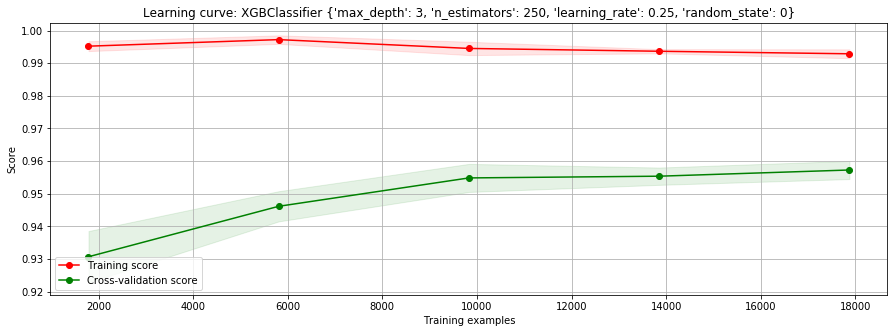

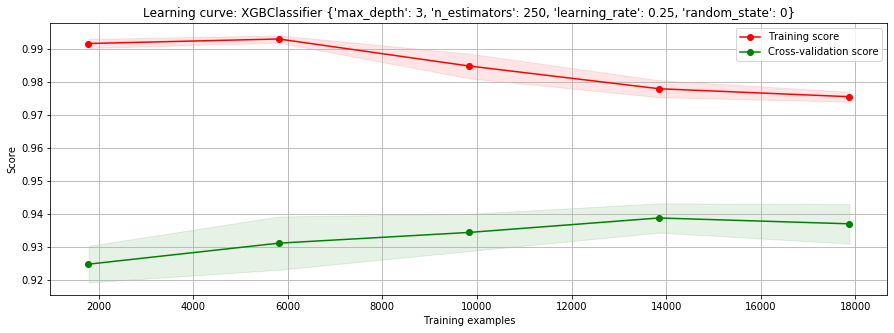

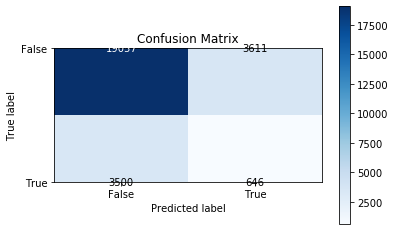

In [26]:
black_list = [
    'is_canceled', 'is_test', 'is_canceled_pred', 'total_return', 'total_return_pred', 'index', 'level_0',
    'invoice'
]
    
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns    
    return [x for x in feats if x not in black_list]

def get_feats(df):
    return [
        "canceled_customer_per_month",
        "canceled_count_customer_month",
        
        "invoice_total_items_bought",
        "customer_total_canceled_amount_spent",
        
        "canceled_per_month",
        "customer_total_invoices",
        
        "similliar_invoice",
        "invoice_price_in_1", "invoice_1th_importance_times_canceled_month", "canceled_per_month", 
        "invoice_price_in_2", "invoice_2th_importance_times_canceled_month", "canceled_per_month_stock_code_date_2",
        "invoice_price_in_3", "invoice_3th_importance_times_canceled_month", "canceled_per_month_stock_code_date_3",
        "invoice_4th_importance_times_canceled_month", "canceled_per_month_stock_code_date_4",
        "invoice_5th_importance_times_canceled_month", "canceled_per_month_stock_code_date_5",
    ]


xgb_params = {'max_depth': 3, 'n_estimators': 250, 'learning_rate': 0.25, 'random_state': 0}

run_cv(
    get_train(df_stats),
    xgb.XGBClassifier, 
    xgb_params
)


In [27]:
train = get_train(df_stats)
train["is_canceled_0th_pred"] = np.nan
train["is_canceled_1th_pred"] = np.nan
train["is_canceled_2th_pred"] = np.nan

feats = get_feats(train)
print(train.shape)    
print(feats)
X = train[feats].values
y = train['is_canceled'].values
    
cv = CustomCV(train['customer_id'], train.index)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):    
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test   = X[test_idx], y[test_idx]

    model = xgb.XGBClassifier(**xgb_params)

    model.fit(X_train, y_train)
    update_test_fold(model.predict(X_test), train, cv.get_index(), test_idx, f"is_canceled_{i}th_pred")
    

(26814, 130)
['canceled_customer_per_month', 'canceled_count_customer_month', 'invoice_total_items_bought', 'customer_total_canceled_amount_spent', 'canceled_per_month', 'customer_total_invoices', 'similliar_invoice', 'invoice_price_in_1', 'invoice_1th_importance_times_canceled_month', 'canceled_per_month', 'invoice_price_in_2', 'invoice_2th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_2', 'invoice_price_in_3', 'invoice_3th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_3', 'invoice_4th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_4', 'invoice_5th_importance_times_canceled_month', 'canceled_per_month_stock_code_date_5']


In [34]:
# analyse mistakes
results = train[["invoice", "invoice_total_price", "customer_id", "is_canceled", "is_canceled_0th_pred", "is_canceled_1th_pred", "is_canceled_2th_pred"]]
results[
    (   ((results["is_canceled_0th_pred"] != results["is_canceled"]) & (~results["is_canceled_0th_pred"].isna()))
     |  ((results["is_canceled_1th_pred"] != results["is_canceled"]) & (~results["is_canceled_1th_pred"].isna()))
     |  ((results["is_canceled_2th_pred"] != results["is_canceled"]) & (~results["is_canceled_2th_pred"].isna()))
    )
]

,invoice,invoice_total_price,customer_id,is_canceled,is_canceled_0th_pred,is_canceled_1th_pred,is_canceled_2th_pred
11,22,1197.800049,17,False,NaN,True,NaN
14,25,12.600000,18,True,NaN,False,NaN
15,26,251.100006,19,False,NaN,NaN,True
16,29,255.500000,22,False,NaN,True,NaN
20,34,733.630005,27,False,NaN,True,NaN
...,...,...,...,...,...,...,...
26792,53588,168469.593750,3689,True,NaN,False,NaN
26794,53590,407.679993,2127,False,NaN,True,NaN
26797,53594,32.529999,4925,True,False,NaN,NaN
26806,53613,7.500000,3574,True,NaN,NaN,False


In [29]:
train[train["invoice_total_price"] == 168469.593750][["is_canceled", "similliar_invoice"]]

,is_canceled,similliar_invoice
26791,False,9999999.0
26792,True,720.0


In [30]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [36]:
train[train["invoice"] == 22]

,invoice,customer_id,country,invoice_date,invoice_total_price,invoice_total_items_bought,invoice_total_quantity,is_canceled,inv_month,customer_total_quantity,customer_total_items,customer_unique_items,customer_total_invoices,customer_canceled_invoices,similliar_invoice,canceled_count_customer_month,ordered_count_customer_month,canceled_customer_per_month,customer_total_amount_spent,customer_total_canceled_amount_spent,invoice_stock_code_1,invoice_stock_code_2,invoice_stock_code_3,invoice_stock_code_4,invoice_stock_code_5,invoice_stock_code_6,invoice_stock_code_7,invoice_stock_code_8,invoice_stock_code_9,invoice_stock_code_10,invoice_price_in_1,invoice_price_in_2,invoice_price_in_3,invoice_price_in_4,invoice_price_in_5,invoice_price_in_6,invoice_price_in_7,invoice_price_in_8,invoice_price_in_9,invoice_price_in_10,product_canceled_times,product_bought_times,product_canceled_avg,product_canceled_times_stock_code_2,product_bought_times_stock_code_2,product_canceled_avg_stock_code_2,product_canceled_times_stock_code_3,product_bought_times_stock_code_3,product_canceled_avg_stock_code_3,product_canceled_times_stock_code_4,product_bought_times_stock_code_4,product_canceled_avg_stock_code_4,product_canceled_times_stock_code_5,product_bought_times_stock_code_5,product_canceled_avg_stock_code_5,product_canceled_times_stock_code_6,product_bought_times_stock_code_6,product_canceled_avg_stock_code_6,product_canceled_times_stock_code_7,product_bought_times_stock_code_7,product_canceled_avg_stock_code_7,product_canceled_times_stock_code_8,product_bought_times_stock_code_8,product_canceled_avg_stock_code_8,product_canceled_times_stock_code_9,product_bought_times_stock_code_9,product_canceled_avg_stock_code_9,product_canceled_times_stock_code_10,product_bought_times_stock_code_10,product_canceled_avg_stock_code_10,canceled_count_month,ordered_count_month,canceled_per_month,canceled_count_month_stock_code_date_2,ordered_count_month_stock_code_date_2,canceled_per_month_stock_code_date_2,canceled_count_month_stock_code_date_3,ordered_count_month_stock_code_date_3,canceled_per_month_stock_code_date_3,canceled_count_month_stock_code_date_4,ordered_count_month_stock_code_date_4,canceled_per_month_stock_code_date_4,canceled_count_month_stock_code_date_5,ordered_count_month_stock_code_date_5,canceled_per_month_stock_code_date_5,canceled_count_month_stock_code_date_6,ordered_count_month_stock_code_date_6,canceled_per_month_stock_code_date_6,canceled_count_month_stock_code_date_7,ordered_count_month_stock_code_date_7,canceled_per_month_stock_code_date_7,canceled_count_month_stock_code_date_8,ordered_count_month_stock_code_date_8,canceled_per_month_stock_code_date_8,canceled_count_month_stock_code_date_9,ordered_count_month_stock_code_date_9,canceled_per_month_stock_code_date_9,canceled_count_month_stock_code_date_10,ordered_count_month_stock_code_date_10,canceled_per_month_stock_code_date_10,invoice_1th_product_importance,invoice_1th_importance_times_canceled,invoice_1th_importance_times_canceled_month,invoice_2th_product_importance,invoice_2th_importance_times_canceled,invoice_2th_importance_times_canceled_month,invoice_3th_product_importance,invoice_3th_importance_times_canceled,invoice_3th_importance_times_canceled_month,invoice_4th_product_importance,invoice_4th_importance_times_canceled,invoice_4th_importance_times_canceled_month,invoice_5th_product_importance,invoice_5th_importance_times_canceled,invoice_5th_importance_times_canceled_month,invoice_6th_product_importance,invoice_6th_importance_times_canceled,invoice_6th_importance_times_canceled_month,invoice_7th_product_importance,invoice_7th_importance_times_canceled,invoice_7th_importance_times_canceled_month,invoice_8th_product_importance,invoice_8th_importance_times_canceled,invoice_8th_importance_times_canceled_month,invoice_9th_product_importance,invoice_9th_importance_times_canceled,invoice_9th_importance_times_canceled_month,is_canceled_0th_pred,is_canceled_1th_pred,is_canceled_2th_pred
11,

In [38]:
raw[raw["invoice"] == 22].sort_values(by=["price_total"])

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,inv_month
273,22,206,RETRO BLUE SPOTTY WASHING UP GLOVES,8,2009-12-01 10:52:00,2.099609,16.799999,17,United Kingdom,False,False,2009-12
275,22,108,RETRO RED SPOTTY WASHING UP GLOVES,8,2009-12-01 10:52:00,2.099609,16.799999,17,United Kingdom,False,False,2009-12
274,22,207,RETRO PINK SPOT WASHING UP GLOVES,8,2009-12-01 10:52:00,2.099609,16.799999,17,United Kingdom,False,False,2009-12
279,22,210,FAWN BLUE HOT WATER BOTTLE,8,2009-12-01 10:52:00,2.949219,23.600000,17,United Kingdom,False,False,2009-12
276,22,208,FUNKY WASHING UP GLOVES ASSORTED,12,2009-12-01 10:52:00,2.099609,25.200001,17,United Kingdom,False,False,2009-12
277,22,209,DOOR MAT FAIRY CAKE,4,2009-12-01 10:52:00,6.750000,27.000000,17,United Kingdom,False,False,2009-12
281,22,212,VINTAGE CREAM 3 BASKET CAKE STAND,4,2009-12-01 10:52:00,9.953125,39.799999,17,United Kingdom,False,False,2009-12
278,22,138,HOT WATER BOTTLE TEA AND SYMPATHY,12,2009-12-01 10:52:00,3.949219,47.400002,17,United Kingdom,False,False,2009-12
272,22,130,RED HANGING HEART T-LIGHT HOLDER,20,2009-12-01 10:52:00,2.949219,59.000000,17,United Kingdom,False,False,2009-12
264,22,200,"FOLDING UMBRELLA , BLACK/BLUE SPOT",12,2009-12-01 10:52:00,4.949219,59.400002,17,United Kingdom,False,False,2009-12


In [31]:
train[train["invoice"] == 42]

,invoice,customer_id,country,invoice_date,invoice_total_price,invoice_total_items_bought,invoice_total_quantity,is_canceled,inv_month,customer_total_quantity,customer_total_items,customer_unique_items,customer_total_invoices,customer_canceled_invoices,similliar_invoice,canceled_count_customer_month,ordered_count_customer_month,canceled_customer_per_month,customer_total_amount_spent,customer_total_canceled_amount_spent,invoice_stock_code_1,invoice_stock_code_2,invoice_stock_code_3,invoice_stock_code_4,invoice_stock_code_5,invoice_stock_code_6,invoice_stock_code_7,invoice_stock_code_8,invoice_stock_code_9,invoice_stock_code_10,invoice_price_in_1,invoice_price_in_2,invoice_price_in_3,invoice_price_in_4,invoice_price_in_5,invoice_price_in_6,invoice_price_in_7,invoice_price_in_8,invoice_price_in_9,invoice_price_in_10,product_canceled_times,product_bought_times,product_canceled_avg,product_canceled_times_stock_code_2,product_bought_times_stock_code_2,product_canceled_avg_stock_code_2,product_canceled_times_stock_code_3,product_bought_times_stock_code_3,product_canceled_avg_stock_code_3,product_canceled_times_stock_code_4,product_bought_times_stock_code_4,product_canceled_avg_stock_code_4,product_canceled_times_stock_code_5,product_bought_times_stock_code_5,product_canceled_avg_stock_code_5,product_canceled_times_stock_code_6,product_bought_times_stock_code_6,product_canceled_avg_stock_code_6,product_canceled_times_stock_code_7,product_bought_times_stock_code_7,product_canceled_avg_stock_code_7,product_canceled_times_stock_code_8,product_bought_times_stock_code_8,product_canceled_avg_stock_code_8,product_canceled_times_stock_code_9,product_bought_times_stock_code_9,product_canceled_avg_stock_code_9,product_canceled_times_stock_code_10,product_bought_times_stock_code_10,product_canceled_avg_stock_code_10,canceled_count_month,ordered_count_month,canceled_per_month,canceled_count_month_stock_code_date_2,ordered_count_month_stock_code_date_2,canceled_per_month_stock_code_date_2,canceled_count_month_stock_code_date_3,ordered_count_month_stock_code_date_3,canceled_per_month_stock_code_date_3,canceled_count_month_stock_code_date_4,ordered_count_month_stock_code_date_4,canceled_per_month_stock_code_date_4,canceled_count_month_stock_code_date_5,ordered_count_month_stock_code_date_5,canceled_per_month_stock_code_date_5,canceled_count_month_stock_code_date_6,ordered_count_month_stock_code_date_6,canceled_per_month_stock_code_date_6,canceled_count_month_stock_code_date_7,ordered_count_month_stock_code_date_7,canceled_per_month_stock_code_date_7,canceled_count_month_stock_code_date_8,ordered_count_month_stock_code_date_8,canceled_per_month_stock_code_date_8,canceled_count_month_stock_code_date_9,ordered_count_month_stock_code_date_9,canceled_per_month_stock_code_date_9,canceled_count_month_stock_code_date_10,ordered_count_month_stock_code_date_10,canceled_per_month_stock_code_date_10,invoice_1th_product_importance,invoice_1th_importance_times_canceled,invoice_1th_importance_times_canceled_month,invoice_2th_product_importance,invoice_2th_importance_times_canceled,invoice_2th_importance_times_canceled_month,invoice_3th_product_importance,invoice_3th_importance_times_canceled,invoice_3th_importance_times_canceled_month,invoice_4th_product_importance,invoice_4th_importance_times_canceled,invoice_4th_importance_times_canceled_month,invoice_5th_product_importance,invoice_5th_importance_times_canceled,invoice_5th_importance_times_canceled_month,invoice_6th_product_importance,invoice_6th_importance_times_canceled,invoice_6th_importance_times_canceled_month,invoice_7th_product_importance,invoice_7th_importance_times_canceled,invoice_7th_importance_times_canceled_month,invoice_8th_product_importance,invoice_8th_importance_times_canceled,invoice_8th_importance_times_canceled_month,invoice_9th_product_importance,invoice_9th_importance_times_canceled,invoice_9th_importance_times_canceled_month,is_canceled_0th_pred,is_canceled_1th_pred,is_canceled_2th_pred
23,

In [32]:
raw[raw["customer_id"] == 33]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,inv_month
626,42,0,15CM CHRISTMAS GLASS BALL 20 LIGHTS,1,2009-12-01 11:50:00,7.949219,7.950000,33,United Kingdom,True,False,2009-12
94610,5223,86,POSTAGE,1,2010-02-18 09:54:00,2.140625,2.140000,33,United Kingdom,True,False,2010-02
94611,5223,400,TRADITIONAL CHRISTMAS RIBBONS,12,2010-02-18 09:54:00,1.250000,15.000000,33,United Kingdom,True,False,2010-02
72094,30898,640,STRAWBERRY LUNCH BOX WITH CUTLERY,1,2011-01-26 13:40:00,2.550781,2.550000,33,United Kingdom,False,False,2011-01
72095,30898,135,HEART FILIGREE DOVE SMALL,24,2011-01-26 13:40:00,1.250000,30.000000,33,United Kingdom,False,False,2011-01
72096,30898,4636,SET OF 3 CAKE TINS PANTRY DESIGN,4,2011-01-26 13:40:00,4.949219,19.799999,33,United Kingdom,False,False,2011-01
72097,30898,871,IVORY HANGING DECORATION HEART,12,2011-01-26 13:40:00,0.850098,10.200000,33,United Kingdom,False,False,2011-01
72098,30898,444,SET/10 PINK POLKADOT PARTY CANDLES,6,2011-01-26 13:40:00,1.250000,7.500000,33,United Kingdom,False,False,2011-01
72099,30898,1801,S/12 VANILLA BOTANICAL T-LIGHTS,6,2011-01-26 13:40:00,2.949219,17.700001,33,United Kingdom,False,False,2011-01
72100,30898,1465,SET 12 LAVENDER BOTANICAL T-LIGHTS,6,2011-01-26 13:40:00,2.949219,17.700001,33,United Kingdom,False,False,2011-01


In [33]:
# !kaggle competitions leaderboard -c online-retail --show